# EON Data Science Challenge

This notebook is going to explain steps of my solution for DS challenge. The final source code can be found in *eon_ds* directory. The *README.txt* file in that folder explain how to install the package.

Please note that cell bellow contains functions which I decided I need, after a quick EDA i.e. the story starts from second cell and all functions will be explained.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

def plz_normalizer(plz):
    plz = str(int(float(plz)))
    if len(plz)==4:
        return '0'+plz
    else:
        return plz
    
def load_data(csv_path):
    data = pd.read_csv('interview_signup.csv', 
                   low_memory=False, 
                   parse_dates=["order_date"],
                   date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d"))
    data = data[~data.bundesland.isna()]
    data['postcode'] = data.postcode.apply(lambda x:plz_normalizer(x))
    data['original_product_name'] = data.original_product_name.apply(lambda x: 'E.ON STROM 24' if 'E.ON STROM 24' in x else x)
    conflicts = data.groupby('postcode').filter(lambda g: (g.bundesland.nunique() > 1)).drop_duplicates(['postcode', 'bundesland'])
    data = data[~data.postcode.isin(conflicts.postcode.unique().tolist())]
    data = data.reset_index(drop=True)
    
    return data

Let's just load the data first:

In [2]:
data = pd.read_csv('interview_signup.csv', 
                   low_memory=False, 
                   parse_dates=["order_date"],
                   date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d"))
data.head()

,original_product_name,postcode,bundesland,total_bonus,order_date
0,E.ON STROM,53229,Nordrhein-Westfalen,146.0,2018-01-01
1,E.ON STROM ÖKO,74235.0,Baden-Württemberg,67.0,2018-01-01
2,E.ON STROM ÖKO 24,45257,Nordrhein-Westfalen,123.0,2018-01-01
3,E.ON STROM,64395,Hessen,159.0,2018-01-01
4,E.ON STROM 24,36039,Hessen,116.0,2018-01-01


Well, trivial steps of preprocessing and/or EDA are:
1. Missing values and their fractions must be checked
2. **order_date** is spread into two columns month and day
3. **postcode** is a mix of integers and floats. Needs to be inspected and normalized
4. **original_product_name** and **bundesland** needs to be checked fo strange values
5. **total_bonus** needs to be checked for outliers and understanding of its PDF

Firstly, let's count missing values:

In [3]:
100*data.isna().sum()/len(data)

original_product_name    0.000000
postcode                 0.000000
bundesland               9.276728
total_bonus              0.000000
order_date               0.000000
dtype: float64

PLZ should be 5 digits (in any format). Let's check length of PLZ strings as they seem strange:

In [4]:
data.postcode.map(str).map(len).value_counts()

5     227014
7      74715
4      12717
6       3898
10         1
Name: postcode, dtype: int64

Bundesland has less than 10% missing values. In this task I simply drop. PLZ has strange values (an example of a PLZ with 10 characters is shown below) and it needs more inspection:

In [5]:
data[data.postcode.map(str).map(len)==10]

,original_product_name,postcode,bundesland,total_bonus,order_date
266922,E.ON STROM,92696JAVAS,NaN,97.0,2018-11-03


Let's start cleaning these two by dropping missing values:

In [6]:
data = data[~data.bundesland.isna()]

Now we check PLZ values:

In [7]:
data.postcode.map(str).map(len).value_counts()

5    206903
7     68520
4     10301
6      3089
Name: postcode, dtype: int64

Let's see an example of each PLZ length:

In [8]:
for l in [4,5,6,7]:
    print(f'{l} characters: {data[data.postcode.map(str).map(len)==l].postcode.iloc[0]} in {data[data.postcode.map(str).map(len)==l].bundesland.iloc[0]}')

4 characters: 7407 in Thüringen
5 characters: 53229 in Nordrhein-Westfalen
6 characters: 4319.0 in Sachsen
7 characters: 74235.0 in Baden-Württemberg


A simple google search shows that **4319.0** is actually a valid PLZ in Saxony (Sachsen)!

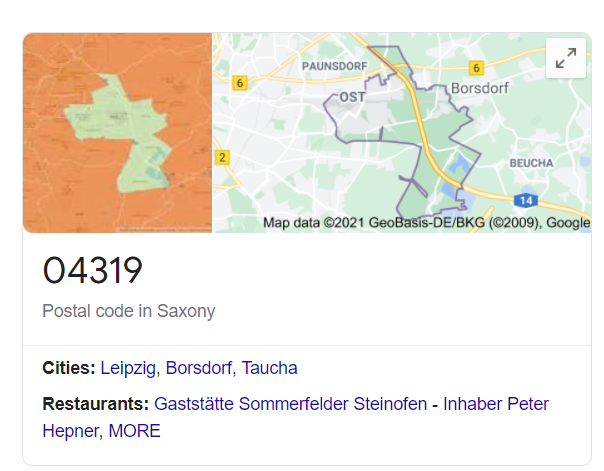

based on this observation, we just normalize those values to 5 digits PLZ. Function **plz_normalizer** in the first cell does this for us and we can check results for one of 4 digit PLZs:

In [9]:
data['postcode'] = data.postcode.apply(lambda x:plz_normalizer(x))
data[data.postcode=='04319'].head(1)

,original_product_name,postcode,bundesland,total_bonus,order_date
24,E.ON STROM,04319,Sachsen,55.0,2018-01-01


Let's go on with checking values and their counts for **bundesland** and **original_product_name**:

In [10]:
for col in ['bundesland', 'original_product_name']:
    print(f'Frequency of categories for {col}:')
    display(data[col].value_counts())
    print()

Frequency of categories for bundesland:


Nordrhein-Westfalen       68541
Bayern                    50741
Baden-Württemberg         35447
Niedersachsen             34885
Hessen                    19898
Rheinland-Pfalz           16348
Schleswig-Holstein        12961
Brandenburg                8799
Sachsen                    8642
Berlin                     8262
Thüringen                  5972
Mecklenburg-Vorpommern     5480
Sachsen-Anhalt             4455
Hamburg                    3953
Saarland                   2989
Bremen                     1440
Name: bundesland, dtype: int64


Frequency of categories for original_product_name:


E.ON STROM                         149424
E.ON STROM 24                       62129
E.ON STROM ÖKO                      50543
E.ON STROM ÖKO 24                   23226
E.ON STROM PUR                       3293
E.ON STROM Ã–KO                       181
E.ON STROM 24 24                       13
E.ON STROM 24 24 24                     2
E.ON STROM 24 24 24 24 24 24 24         2
Name: original_product_name, dtype: int64

Bundesland sounds intially fine but there are outliers in product name. Considering the name and frequency, I assume that all **E.ON STROM 24** values are the same (dropping would also be fine). In production it will be verified by PO.

In [11]:
data['original_product_name'] = data.original_product_name.apply(lambda x: 'E.ON STROM 24' if 'E.ON STROM 24' in x else x)
data.original_product_name.value_counts()

E.ON STROM           149424
E.ON STROM 24         62146
E.ON STROM ÖKO        50543
E.ON STROM ÖKO 24     23226
E.ON STROM PUR         3293
E.ON STROM Ã–KO         181
Name: original_product_name, dtype: int64

**E.ON STROM Ã–KO** seems also strange but no business domain knowledge is in hand so I let it be.

Let's check if bundeslands and PLZ values agree:

In [12]:
conflicts = data.groupby('postcode').filter(lambda g: (g.bundesland.nunique() > 1)).drop_duplicates(['postcode', 'bundesland'])
display(conflicts.sort_values('postcode')[['postcode', 'bundesland']])

print(f'{len(data[data.postcode.isin(conflicts.postcode.unique().tolist())])} rows have PLZ-Bundesland conflict')

,postcode,bundesland
35880,14715,Sachsen-Anhalt
5674,14715,Brandenburg
44011,17337,Brandenburg
32147,17337,Mecklenburg-Vorpommern
272930,19357,Mecklenburg-Vorpommern
103370,19357,Brandenburg
775,21039,Schleswig-Holstein
30147,21039,Hamburg
32940,22113,Hamburg
17914,22113,Schleswig-Holstein


344 rows have PLZ-Bundesland conflict


There are conflicts between bundeslands and PLZ values for 9 postal codes. It can be easily checked for correction but here I just drop as they are not many:

In [13]:
data = data[~data.postcode.isin(conflicts.postcode.unique().tolist())]
data.shape

(288469, 5)

A collection of all these steps is implemented in **load_data** function in the first cell.

We are going to have look at **total_bonus** as last column:

<AxesSubplot:>

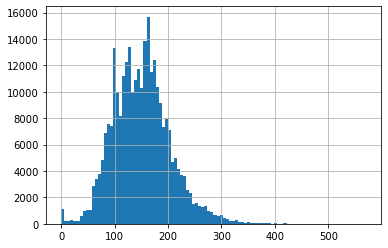

In [14]:
data.total_bonus.hist(bins=100)

A bit skewed Gaussian which is fine for now. Let's see if histograms of different bundeslands shows any obvious outlier: 

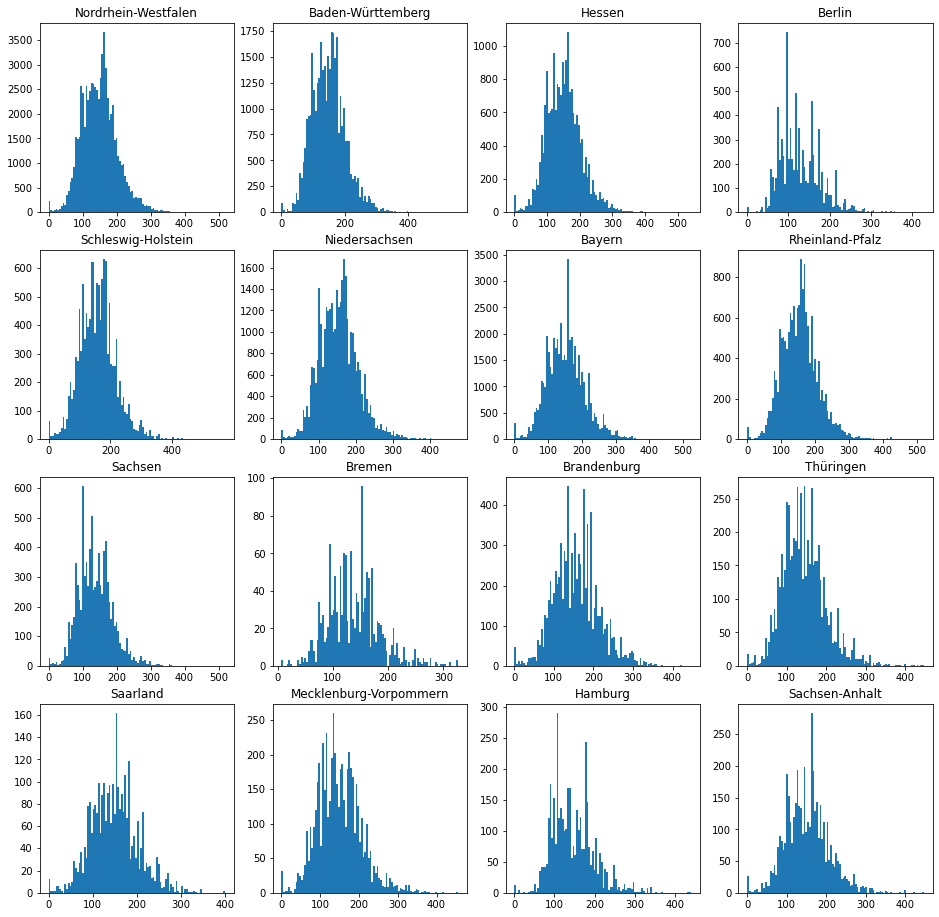

In [15]:
plt.figure(figsize=(16,16))

x = 1
for land in data.bundesland.unique():
    plt.subplot(4,4,x)
    plt.hist(data[data.bundesland==land].total_bonus, bins=100)
    plt.title(land)
    x += 1
plt.show()

No obvious pattern which neccesiates a preprocessing. What about total bonus according to products?

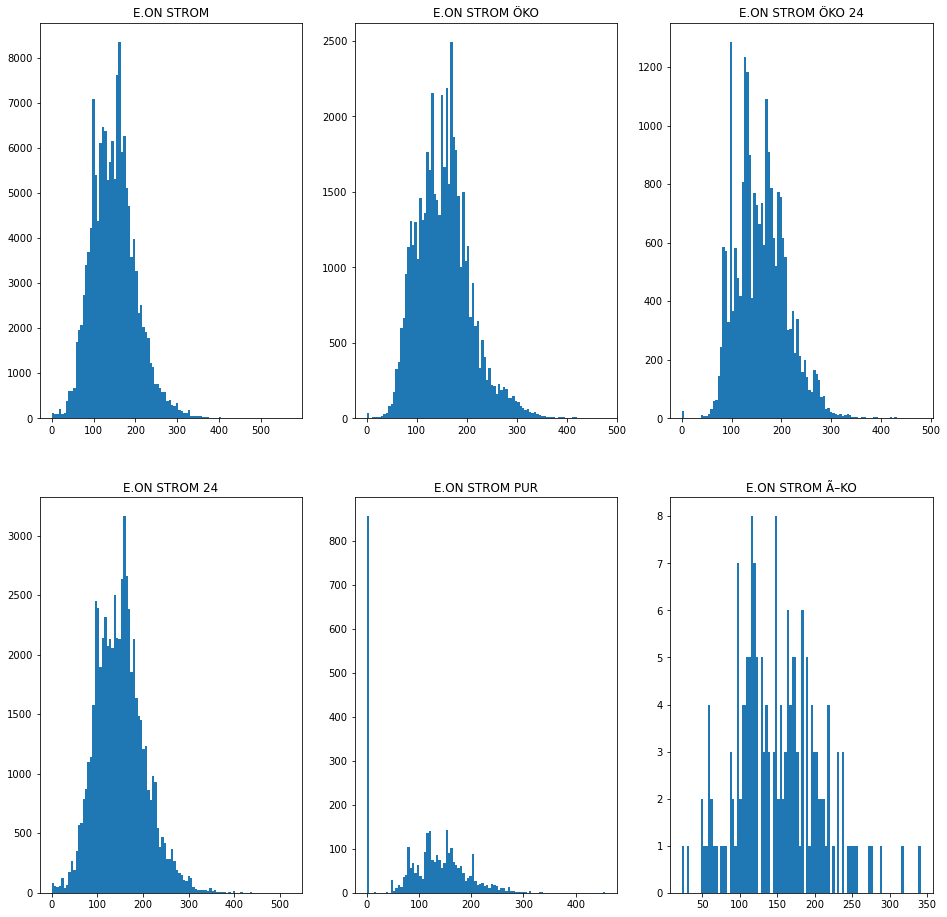

In [16]:
plt.figure(figsize=(16,16))

x = 1
for product in data.original_product_name.unique():
    plt.subplot(2,3,x)
    plt.hist(data[data.original_product_name==product].total_bonus, bins=100)
    plt.title(product)
    x += 1
plt.show()

Things look fine, only **E.ON STROM PUR** has a significant amount of low bonuses:

In [17]:
data[(data.original_product_name == 'E.ON STROM PUR') & (data.total_bonus == 0)]

,original_product_name,postcode,bundesland,total_bonus,order_date
378,E.ON STROM PUR,27624,Niedersachsen,0.0,2018-01-01
401,E.ON STROM PUR,93053,Bayern,0.0,2018-01-01
1108,E.ON STROM PUR,56154,Rheinland-Pfalz,0.0,2018-01-02
1358,E.ON STROM PUR,24852,Schleswig-Holstein,0.0,2018-01-02
1626,E.ON STROM PUR,16244,Brandenburg,0.0,2018-01-02
...,...,...,...,...,...
316217,E.ON STROM PUR,57629,Rheinland-Pfalz,0.0,2018-12-29
317349,E.ON STROM PUR,29353,Niedersachsen,0.0,2018-12-30
317551,E.ON STROM PUR,95689,Bayern,0.0,2018-12-31
317738,E.ON STROM PUR,41836,Nordrhein-Westfalen,0.0,2018-12-31
